# GOUT-CC-2019-CORPUS Analysis
## From "Identification of Gout Flares in Chief Complaint Text Using Natural Language Processing, AMIA 2020 (accepted)"
###  Requires Physionet de-identified data file CC-2019-CORPUS-PAPER.tsv to run  (release pending)

## Gout Mention Data Import, Clean and Display

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('CC-2019-CORPUS-PAPER.tsv', delimiter='\t')

print(df)
predict = df['Predict'].value_counts()
print(predict)
consensus = df['Consensus'].value_counts()
print(consensus)


                                       Chief Complaint Predict Consensus
0    "been feeling bad" last 2 weeks & switched BP ...       N         -
1    "can't walk", reports onset at 6pm. oriented x...       Y         N
2    "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3    "gout flare up" L arm swelling x 1 week. denie...       Y         Y
4    "heart racing,"dyspnea, and orthopnea that has...       N         -
..                                                 ...     ...       ...
295  upper abd/R side chest pain x1 month, new onse...       N         N
296  upper lip swelling x one day, pmh HTN, COPD, b...       N         N
297  walked outside of a gas station and began bein...       N         -
298  was getting prepped for colonoscopy and was se...       N         N
299  Was seen at <<HOSPITAL>> after an MVC. Pt stat...       N         N

[300 rows x 3 columns]
N    176
Y     97
U     27
Name: Predict, dtype: int64
N    118
-    103
Y     70
U      9
Name: Con

## Gout Dictionary

In [2]:
# Gout Body Locations
#Skipping stemming locations, vocabulary is small
goutBodyLocation = ['ARM','HIP','SHOULDER','WRIST','ANKLE','KNEE','TOE','FOOT','FEET','LEG','ELBOW','FINGER','THUMB']
goutBodyLocationAbbreviations = ['LLE','LUE','RUE','RLE','LE','UE']

# Past Medical History
pmhx = ['PMH','PMHX','HX','PMX']

# Gout Keywords from Table 1. https://onlinelibrary.wiley.com/doi/full/10.1002/acr.22324
gout_keywords=['gout','podagra','tophaceous','tophi','tophus']

#Alternative Gout Related Keywords from Table 1. https://onlinelibrary.wiley.com/doi/full/10.1002/acr.22324
alt_keywords=['acute flare','acute inflammatory process','allopurinol','arthritis','attack','big toe','cellulitis',
'codeine','colchicine','chronic arthritis','corticosteroids', 'diclofenac','edema','elevated levels of uric acid',
'flare','flare up','flare‐up','g6pd    ','gonagra','high uric acid level','hydrocodone','hyperuricemia','ibuprofen'
,'indomethacin','inflammation of joint','joint pain','kidney stone','king\'s disease','metacarpal',
'metacarpophalangeal joint','metatarsal phalangeal','metatarsal‐phalangeal','naprosyn','naproxen','nsaid',
'oxycodone','recu    rrent attacks','red joint','redness and swelling','swelling','swollen joint','synovial biopsy',
'synovial fluid analysis','tender joint','urate lower     drugs','urate‐lowering therapy','urate nephropathy',
'uric acid','uric acid crystals','uric crystals','voltarol','zyloric'
]

## Gout Regular Expressions

In [3]:
import re
goutRegex = re.compile('.*gout.*',re.IGNORECASE)

def fetchGoutDictionaryWord(cc):
    if((re.search("|".join(gout_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(gout_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return findgoutkeyword.group(0);
        return None  

def fetchAltDictionaryWord(cc):
    if((re.search("|".join(alt_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(alt_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return findgoutkeyword.group(0);
        return None   

def hasGoutKeyword(cc):
    if((re.search("|".join(gout_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(gout_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return True;
        return False
    
def hasAltGoutKeyword(cc):
    if((re.search("|".join(alt_keywords), cc.lower())) !=None):        
        findgoutkeyword = (re.search("|".join(alt_keywords), cc.lower()))
        if(findgoutkeyword!=None):
            #print(findgoutkeyword)
            return True;
        return False

def hasGoutPmhx(cc):
    if(goutRegex.match(cc)!=None):
        findgout = (re.search('GOUT', cc.upper())).start()
        if((re.search("|".join(pmhx), cc.upper())) !=None):        
            findpmhx = (re.search("|".join(pmhx), cc.upper())).start()
            if(findgout>findpmhx):
                return True
    return False

def hasGoutCurrent(cc):
    if(goutRegex.match(cc)!=None):
        findgout = (re.search('GOUT', cc.upper())).start()
        if((re.search("|".join(pmhx), cc.upper())) !=None):        
            findpmhx = (re.search("|".join(pmhx), cc.upper())).start()
            if(findgout<findpmhx):
                return True
    return False


def hasGoutBodyLocationCurrent(cc):
    goutblmatch = re.search("|".join(goutBodyLocation), cc.upper())
    if(goutblmatch!=None):
        findgoutbl = goutblmatch.start()
        if((re.search("|".join(pmhx), cc.upper())) !=None):        
            findpmhx = (re.search("|".join(pmhx), cc.upper())).start()
            if(findgoutbl<findpmhx):
                return True
    return False

#################################################
# Test Code
assert(hasGoutCurrent('gout flare - pmh DM'))
assert(hasGoutCurrent('bar fight, multiple abrasions - pmhx gout, HT')==False)
assert(hasGoutPmhx('bar fight, multiple abrasions - pmhx gout, HT'))
assert(hasGoutBodyLocationCurrent('knee pain - pmh DM gout'))
#################################################
#Classifiers

# Replication of Stu's results
def regexGoutClassifier(cc):
    if(goutRegex.match(cc)!=None):
        return '__label__Y'
    else:
        return '__label__N'
      
def regexGoutCurrentClassifier(cc):
    if(hasGoutCurrent(cc)):
        return '__label__Y'
    return '__label__N'

def regexGoutKeywordClassifier(cc):
    if(hasGoutKeyword(cc)):
        return '__label__Y'
    return '__label__N'

def regexAltGoutKeywordClassifier(cc):
    if(hasAltGoutKeyword(cc)):
        return '__label__Y'
    return '__label__N'

def regexGoutBodyLocationOrCurrentGoutClassifier(cc):
    if(goutRegex.match(cc)!=None):
        if(hasGoutBodyLocationCurrent(cc)):
            return '__label__Y'
    if(hasGoutCurrent(cc)):
        return '__label__Y'
    return '__label__N'

def regexGoutBodyLocationAndAnyGoutClassifier(cc):
    if(goutRegex.match(cc)!=None):
        if(hasGoutBodyLocationCurrent(cc)):
            return '__label__Y'
    return '__label__N'

#################################################

## Examples of Discrepancies between Prediction and Consensus
### Rheumatologist asserted gout negative based on CC only

In [6]:
df.rename(columns={'Chief Complaint': 'CC'}, inplace=True)


pred = df['Predict'] == 'Y'
con = df['Consensus'] == 'N'
pd.options.display.max_colwidth = 110
disagree = pd.DataFrame(df[pred & con])['CC']
print(disagree)
len(disagree)



1      "can't walk", reports onset at 6pm. oriented x2. aortic valve replacement in <<DATE>>. wife reports episod...
7      "I want to see if I have an infection" pt vague about symptoms, and having gout flare up, big toe swollen,...
27     bil. knee pain for "a while". fell earlier today d/t the pain. Admits to hitting head, denies LOC. Also c/...
28                          bilat foot poain, r hand pain r/t gout per patient. states ran out of his meds yesterday
31     bilateral knee swelling Left sided chest pain, jaw pain,  BLE swelling, SOB, coughing more often, and weak...
32                            bilateral leg and feet pain. weeping fluid. has CHF. increased leg pain PMH: CHF, gout
58     Called back to ED for positive blood cultures x2. Here <<DATE>> for swelling to right leg, "turning colors...
107    Increased swelling to bilateral feet x 2 weeks, left hip pain x 2 weeks, period has lasted 3 weeks but is ...
142      lower left leg pain x 3 days. ultrasound showed small c

17

## Body Location Gazeeter Locations extracted from Chief Complaint

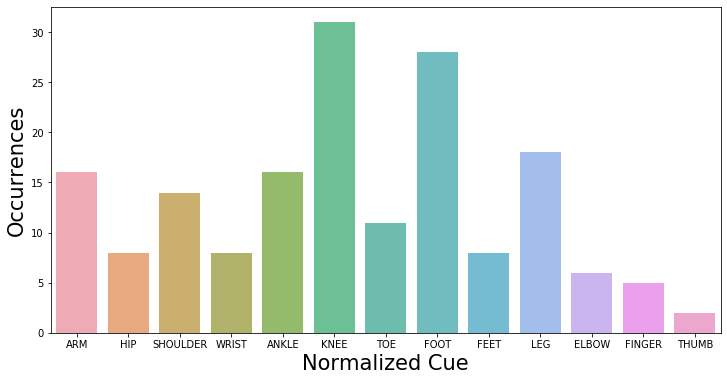

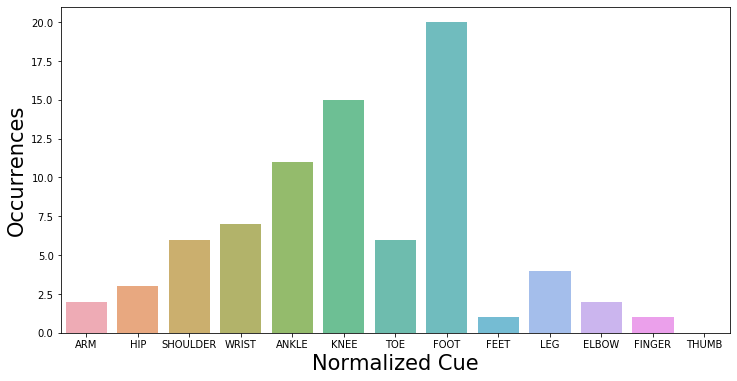

78
46
['ARM', 'HIP', 'SHOULDER', 'WRIST', 'ANKLE', 'KNEE', 'TOE', 'FOOT', 'FEET', 'LEG', 'ELBOW', 'FINGER', 'THUMB']
[2, 3, 6, 7, 11, 15, 6, 20, 1, 4, 2, 1, 0]
[9, 3, 2, 1, 2, 8, 3, 3, 3, 7, 3, 2, 0]
[0.02564102564102564, 0.038461538461538464, 0.07692307692307693, 0.08974358974358974, 0.14102564102564102, 0.19230769230769232, 0.07692307692307693, 0.2564102564102564, 0.01282051282051282, 0.05128205128205128, 0.02564102564102564, 0.01282051282051282, 0.0]
[0.1956521739130435, 0.06521739130434782, 0.043478260869565216, 0.021739130434782608, 0.043478260869565216, 0.17391304347826086, 0.06521739130434782, 0.06521739130434782, 0.06521739130434782, 0.15217391304347827, 0.06521739130434782, 0.043478260869565216, 0.0]
84
148
0.7733333333333333
['PMH', 'PMHX', 'HX', 'PMX']
[46, 11, 26, 1]
[92, 16, 38, 2]


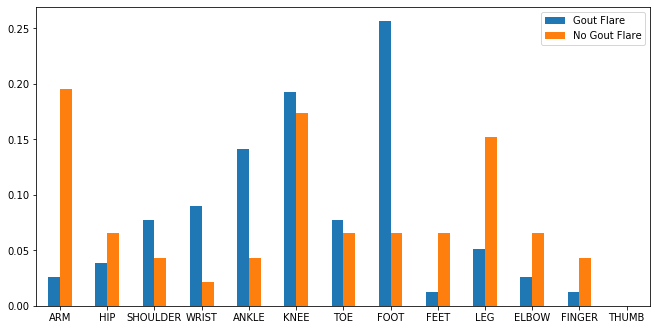

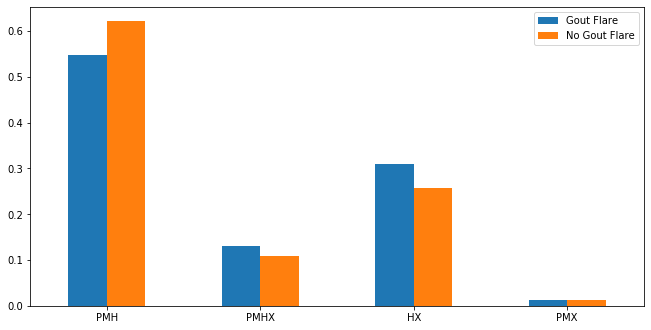

In [9]:
def body2counts(thelist,df,thecase):
    bodydf = pd.DataFrame(df['CC'].copy())
    ccseries = pd.Series(bodydf["CC"])
    counts={}
    for item in thelist:
        bodydf[item] = ccseries.str.contains(item,regex=True,case=thecase)
    for item in thelist:
        countdf = bodydf.loc[bodydf[item] == True]
        counts[item] = len(countdf)   
    return counts



# Plot distribution of body locations in all people
body_count = body2counts(goutBodyLocation,df,False)
bodybits = pd.Series(body_count)
# Plot distribution of PMH
pmh_count = body2counts(pmhx,df,False)
pmhbits = pd.Series(pmh_count)

#print(bodybits)
plt.figure(figsize=(12,6))
sns.barplot(bodybits.index, bodybits.values, alpha=0.8)
#plt.title('Body Location Cues',fontsize='25')
plt.ylabel('Occurrences', fontsize=21)
plt.xlabel('Normalized Cue', fontsize=21)
plt.show()



# SHOW GOUT VS NOT GOUT
goutbitdf = df.loc[df["Consensus"]=='Y']
gout_body_count = body2counts(goutBodyLocation,goutbitdf,False)
goutbodybits = pd.Series(gout_body_count)
plt.figure(figsize=(12,6))
sns.barplot(goutbodybits.index, goutbodybits.values, alpha=0.8)
plt.ylabel('Occurrences', fontsize=21)
plt.xlabel('Normalized Cue', fontsize=21)
plt.show()

notgoutbitdf = df.loc[df["Consensus"]=='N']
notgout_body_count = body2counts(goutBodyLocation,notgoutbitdf,False)
notgoutbodybits = pd.Series(notgout_body_count)

#print(goutbodybits)
index=[*bodybits.keys()]
gout=[*gout_body_count.values()]
notgout=[*notgout_body_count.values()]

goutfolks = 0
notgoutfolks = 0
for num in gout:
    goutfolks = num + goutfolks
for num in notgout:
    notgoutfolks = num + notgoutfolks
print(goutfolks)
print(notgoutfolks)

goutpercent = [x / goutfolks for x in gout]
notgoutpercent = [x / notgoutfolks for x in notgout]

print(index)
print(gout)
print(notgout)
print(goutpercent)
print(notgoutpercent)

#goutDifdf = pd.DataFrame({'Gout': gout}, index=index)
#ax = goutDifdf.plot.bar(rot=0)
#goutDifdf = pd.DataFrame({'No Gout': notgout}, index=index)
#ax = goutDifdf.plot.bar(rot=0)
goutDifdf = pd.DataFrame({'Gout Flare': goutpercent,'No Gout Flare': notgoutpercent}, index=index)
ax = goutDifdf.plot.bar(rot=0,figsize=(11,5.5))
#goutDifdf = pd.DataFrame({'Gout Flare': gout,'No Gout Flare': notgout}, index=index)
#ax = goutDifdf.plot.bar(rot=0,figsize=(11,5.5))

#### PMH Gout Chart
index=[*pmhbits.keys()]
gout_pmh_count = body2counts(pmhx,goutbitdf,False)
goutpmhbits = pd.Series(gout_pmh_count)
notgout_pmh_count = body2counts(pmhx,notgoutbitdf,False)
notgoutpmhbits = pd.Series(notgout_pmh_count)
index=[*pmhbits.keys()]
gout=[*gout_pmh_count.values()]
notgout=[*notgout_pmh_count.values()]


goutfolks = 0
notgoutfolks = 0
for num in gout:
    goutfolks = num + goutfolks
for num in notgout:
    notgoutfolks = num + notgoutfolks
print(goutfolks)
print(notgoutfolks)
print((goutfolks+notgoutfolks)/300)
goutpercent = [x / goutfolks for x in gout]
notgoutpercent = [x / notgoutfolks for x in notgout]

print(index)
print(gout)
print(notgout)
goutDifdf = pd.DataFrame({'Gout Flare': goutpercent,'No Gout Flare': notgoutpercent}, index=index)
ax = goutDifdf.plot.bar(rot=0,figsize=(11,5.5))




# Abbreviations
abbr_body_count = body2counts(goutBodyLocationAbbreviations,df,True)
abbrbodybits = pd.Series(abbr_body_count)
#print(abbrbodybits)

## Predicting Flare Gout Status on Chief Complaint with NLP
### Chart Review Consensus Data
### Divide Chart Review Consensus data into validation, train and test sets


In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
pred_labels=['__label__Y','__label__N','__label__U']


#Format data
data = df[['Consensus', 'CC']].rename(columns={"Consensus":"label", "CC":"text"})
pd.options.display.max_colwidth = 60
data['label'] = '__label__' + data['label'].astype(str)
print(data[1:10])

data.iloc[0:int(len(data)*0.8)].to_csv('train.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.tsv', sep='\t', index = False, header = False);




        label                                                         text
1  __label__N  "can't walk", reports onset at 6pm. oriented x2. aortic ...
2  __label__Y  "dehydration" Chest hurts, hips hurt, cramps PMH- Hip re...
3  __label__Y  "gout flare up" L arm swelling x 1 week. denies any othe...
4  __label__-  "heart racing,"dyspnea, and orthopnea that has been gett...
5  __label__N          "I started breathing hard"  hx- htn, gout, anxiety,
6  __label__Y  "I think I have a gout flare up" L wrist pain & swelling...
7  __label__N  "I want to see if I have an infection" pt vague about sy...
8  __label__Y  "My gout done flared up on me", c/o R ankle, L shoulder,...
9  __label__Y  "my gout is hurting me"- reports bilateral foot pain x 2...


### Regular Expression Based Prediction of Chart Review Gout Flare Status

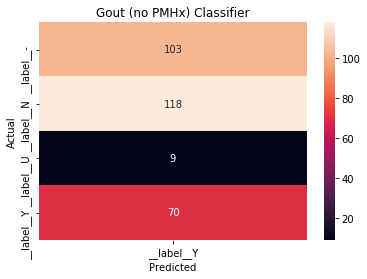

              precision    recall  f1-score   support

  __label__Y       0.23      1.00      0.38        70
  __label__N       0.00      0.00      0.00       118
  __label__U       0.00      0.00      0.00         9

   micro avg       0.23      0.36      0.28       197
   macro avg       0.08      0.33      0.13       197
weighted avg       0.08      0.36      0.13       197



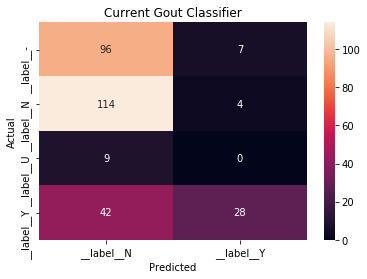

              precision    recall  f1-score   support

  __label__Y       0.72      0.40      0.51        70
  __label__N       0.44      0.97      0.60       118
  __label__U       0.00      0.00      0.00         9

   micro avg       0.47      0.72      0.57       197
   macro avg       0.38      0.46      0.37       197
weighted avg       0.52      0.72      0.54       197



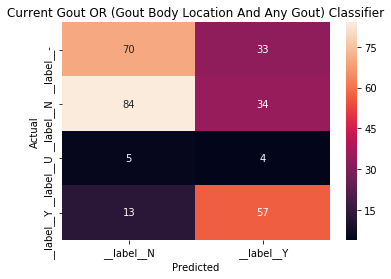

              precision    recall  f1-score   support

  __label__Y       0.45      0.81      0.58        70
  __label__N       0.49      0.71      0.58       118
  __label__U       0.00      0.00      0.00         9

   micro avg       0.47      0.72      0.57       197
   macro avg       0.31      0.51      0.39       197
weighted avg       0.45      0.72      0.55       197



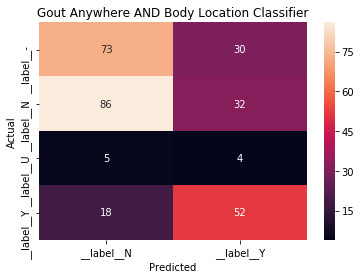

              precision    recall  f1-score   support

  __label__Y       0.44      0.74      0.55        70
  __label__N       0.47      0.73      0.57       118
  __label__U       0.00      0.00      0.00         9

   micro avg       0.46      0.70      0.56       197
   macro avg       0.30      0.49      0.38       197
weighted avg       0.44      0.70      0.54       197



In [18]:
# Test Regular Expression Classifiers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def showConfusionMatrix(heading,y_true,y_pred):
    regex1data  = {'y_Actual': y_true,'y_Predicted': y_pred}
    df = pd.DataFrame(regex1data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'],)
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix, annot=True,fmt="d",ax=ax)
    ax.set_title(heading)
    plt.show()
    print(classification_report(y_true, y_pred, target_names=pred_labels, labels=pred_labels))


y_true = data['label']
#Current Gout Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutClassifier))['text']
title2display='Gout (no PMHx) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Only Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutCurrentClassifier))['text']
title2display='Current Gout Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationOrCurrentGoutClassifier))['text']
title2display='Current Gout OR (Gout Body Location And Any Gout) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationAndAnyGoutClassifier))['text']
title2display='Gout Anywhere AND Body Location Classifier'
showConfusionMatrix(title2display,y_true,y_pred)



## Regular Expression Based Prediction of Likely Gout Flare Status based on Chief Complaint

        label                                                         text
1  __label__Y  "can't walk", reports onset at 6pm. oriented x2. aortic ...
2  __label__Y  "dehydration" Chest hurts, hips hurt, cramps PMH- Hip re...
3  __label__Y  "gout flare up" L arm swelling x 1 week. denies any othe...
4  __label__N  "heart racing,"dyspnea, and orthopnea that has been gett...
5  __label__N          "I started breathing hard"  hx- htn, gout, anxiety,
6  __label__Y  "I think I have a gout flare up" L wrist pain & swelling...
7  __label__Y  "I want to see if I have an infection" pt vague about sy...
8  __label__Y  "My gout done flared up on me", c/o R ankle, L shoulder,...
9  __label__Y  "my gout is hurting me"- reports bilateral foot pain x 2...


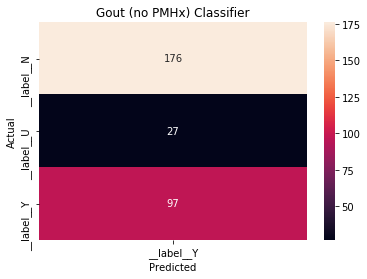

              precision    recall  f1-score   support

  __label__Y       0.32      1.00      0.49        97
  __label__N       0.00      0.00      0.00       176
  __label__U       0.00      0.00      0.00        27

    accuracy                           0.32       300
   macro avg       0.11      0.33      0.16       300
weighted avg       0.10      0.32      0.16       300



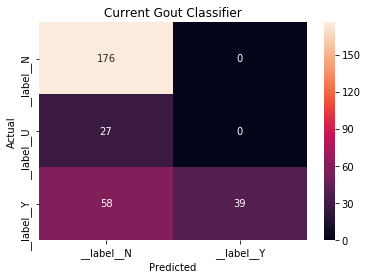

              precision    recall  f1-score   support

  __label__Y       1.00      0.40      0.57        97
  __label__N       0.67      1.00      0.81       176
  __label__U       0.00      0.00      0.00        27

    accuracy                           0.72       300
   macro avg       0.56      0.47      0.46       300
weighted avg       0.72      0.72      0.66       300



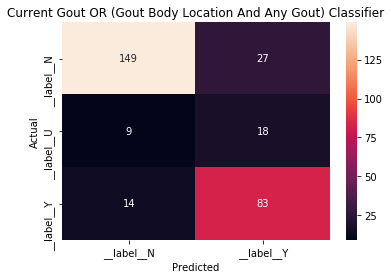

              precision    recall  f1-score   support

  __label__Y       0.65      0.86      0.74        97
  __label__N       0.87      0.85      0.86       176
  __label__U       0.00      0.00      0.00        27

    accuracy                           0.77       300
   macro avg       0.50      0.57      0.53       300
weighted avg       0.72      0.77      0.74       300



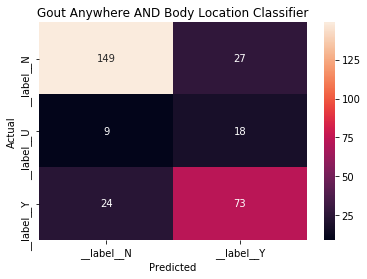

              precision    recall  f1-score   support

  __label__Y       0.62      0.75      0.68        97
  __label__N       0.82      0.85      0.83       176
  __label__U       0.00      0.00      0.00        27

    accuracy                           0.74       300
   macro avg       0.48      0.53      0.50       300
weighted avg       0.68      0.74      0.71       300



In [19]:
#Format data
data = df[['Predict', 'CC']].rename(columns={"Predict":"label", "CC":"text"})
pd.options.display.max_colwidth = 60
data['label'] = '__label__' + data['label'].astype(str)
print(data[1:10])

data.iloc[0:int(len(data)*0.8)].to_csv('train.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.tsv', sep='\t', index = False, header = False);


y_true = data['label']
#Current Gout Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutClassifier))['text']
title2display='Gout (no PMHx) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Only Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutCurrentClassifier))['text']
title2display='Current Gout Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Current Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationOrCurrentGoutClassifier))['text']
title2display='Current Gout OR (Gout Body Location And Any Gout) Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

#Gout Or Current Body Location Classifier
y_pred = (pd.DataFrame(data['text']).applymap(regexGoutBodyLocationAndAnyGoutClassifier))['text']
title2display='Gout Anywhere AND Body Location Classifier'
showConfusionMatrix(title2display,y_true,y_pred)

## BERT Approach
#### Boilerplate GPU/CUDA Validation

In [ ]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

!conda list | grep torch

#### BERT Based Prediction of Chart Reviewed Gout Flare Status

        label                                                         text
1  __label__N  "can't walk", reports onset at 6pm. oriented x2. aortic ...
2  __label__Y  "dehydration" Chest hurts, hips hurt, cramps PMH- Hip re...
3  __label__Y  "gout flare up" L arm swelling x 1 week. denies any othe...
4  __label__-  "heart racing,"dyspnea, and orthopnea that has been gett...
5  __label__N          "I started breathing hard"  hx- htn, gout, anxiety,
6  __label__Y  "I think I have a gout flare up" L wrist pain & swelling...
7  __label__N  "I want to see if I have an infection" pt vague about sy...
8  __label__Y  "My gout done flared up on me", c/o R ankle, L shoulder,...
9  __label__Y  "my gout is hurting me"- reports bilateral foot pain x 2...
2020-07-23 20:42:23,731 Reading data from .
2020-07-23 20:42:23,733 Train: train.tsv
2020-07-23 20:42:23,734 Dev: dev.tsv
2020-07-23 20:42:23,736 Test: test.tsv


/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated function (or staticmethod) load_classification_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/flair/data_fetcher.py:452: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  train_file, tokenizer=tokenizer, max_tokens_per_doc=max_tokens_per_doc
/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/flair/data_fetcher.py:457: DeprecationWarning: Call to deprecated function (or staticmethod) read_text_classification_file. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  test_file, tokenizer=tokenizer, max_tokens_per_doc=max_tokens_per_doc
/data/user/ozborn/Conda_Env/deepnlpv2/lib/python3.6/site-packages/flair/data_fetcher.py:

2020-07-23 20:42:26,465 Computing label dictionary. Progress:


100%|██████████| 240/240 [00:00<00:00, 255945.32it/s]

2020-07-23 20:42:26,472 [b'-', b'N', b'Y', b'U']
2020-07-23 20:42:26,504 ----------------------------------------------------------------------------------------------------
2020-07-23 20:42:26,507 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): BertEmbeddings(
        (model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias

2020-07-23 20:42:26,509 ----------------------------------------------------------------------------------------------------
2020-07-23 20:42:26,511 Corpus: "Corpus: 240 train + 30 dev + 30 test sentences"
2020-07-23 20:42:26,513 ----------------------------------------------------------------------------------------------------
2020-07-23 20:42:26,514 Parameters:
2020-07-23 20:42:26,516  - learning_rate: "0.1"
2020-07-23 20:42:26,517  - mini_batch_size: "10"
2020-07-23 20:42:26,519  - patience: "5"
2020-07-23 20:42:26,520  - anneal_factor: "0.5"
2020-07-23 20:42:26,522  - max_epochs: "4"
2020-07-23 20:42:26,523  - shuffle: "True"
2020-07-23 20:42:26,524  - train_with_dev: "False"
2020-07-23 20:42:26,525  - batch_growth_annealing: "False"
2020-07-23 20:42:26,525 ----------------------------------------------------------------------------------------------------
2020-07-23 20:42:26,526 Model training base path: "."
2020-07-23 20:42:26,527 ------------------------------------------------

2020-07-23 20:42:26,718 epoch 1 - iter 2/24 - loss 1.59432250 - samples/sec: 135.14
2020-07-23 20:42:43,182 epoch 1 - iter 4/24 - loss 2.16661841 - samples/sec: 107.96
2020-07-23 20:42:54,539 epoch 1 - iter 6/24 - loss 2.39600730 - samples/sec: 122.45
2020-07-23 20:43:05,503 epoch 1 - iter 8/24 - loss 2.09651442 - samples/sec: 115.13
2020-07-23 20:43:19,686 epoch 1 - iter 10/24 - loss 2.05180511 - samples/sec: 118.92
2020-07-23 20:43:31,872 epoch 1 - iter 12/24 - loss 1.91244775 - samples/sec: 134.19
2020-07-23 20:43:39,436 epoch 1 - iter 14/24 - loss 1.93304449 - samples/sec: 117.05
2020-07-23 20:43:47,967 epoch 1 - iter 16/24 - loss 1.91059911 - samples/sec: 123.35
2020-07-23 20:43:56,125 epoch 1 - iter 18/24 - loss 1.84983255 - samples/sec: 121.22
2020-07-23 20:44:03,821 epoch 1 - iter 20/24 - loss 1.88247412 - samples/sec: 132.51
2020-07-23 20:44:10,889 epoch 1 - iter 22/24 - loss 1.92602057 - samples/sec: 124.04
2020-07-23 20:44:19,555 epoch 1 - iter 24/24 - loss 1.89923782 - samp

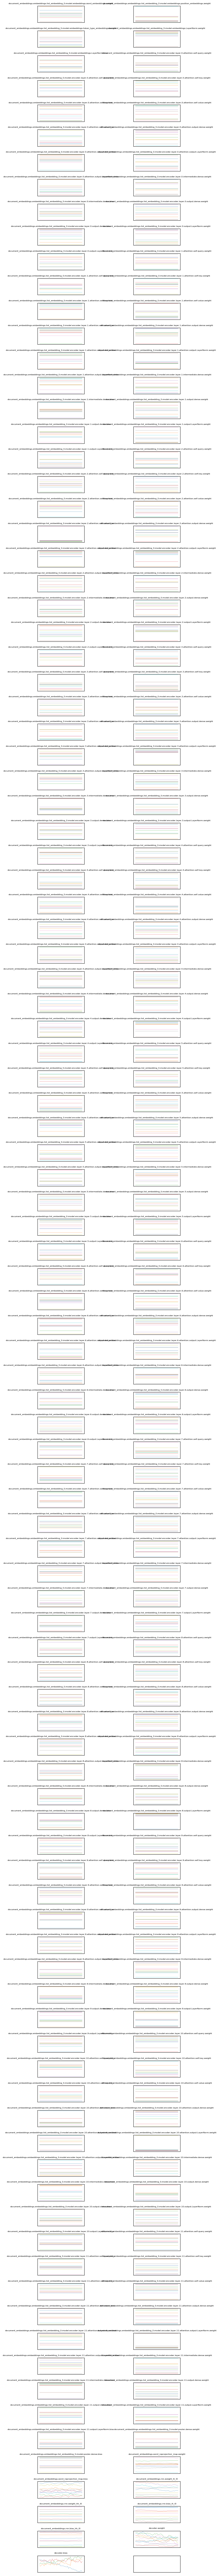

In [21]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.embeddings import StackedEmbeddings
from flair.embeddings import FlairEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

from flair.data import Corpus

from sklearn.model_selection import train_test_split

# 1. Re/Load Chart Review Data and Format Datda
train, test = train_test_split(df, test_size=0.2)
pred_labels=['__label__Y','__label__N','__label__U']
data = df[['Consensus', 'CC']].rename(columns={"Consensus":"label", "CC":"text"})
pd.options.display.max_colwidth = 60
data['label'] = '__label__' + data['label'].astype(str)
print(data[1:10])
data.iloc[0:int(len(data)*0.8)].to_csv('train.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.tsv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.tsv', sep='\t', index = False, header = False);
df = pd.read_csv('CC-2019-CORPUS-PAPER.tsv', delimiter='\t')



# 2. Create corpus
corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'), test_file='test.tsv', dev_file='dev.tsv', train_file='train.tsv')

# 3. Train with BERT

#word_embeddings = [BertEmbeddings('bert-base-cased'),
#                   # comment in flair embeddings for state-of-the-art results
#                   FlairEmbeddings('news-forward'),
#                   FlairEmbeddings('news-backward'),
#                   ]
word_embeddings = [BertEmbeddings('bert-base-uncased'),
                   ]
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )
classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary())

trainer = ModelTrainer(classifier, corpus)
trainer.train('./', 
              learning_rate=0.1,
              mini_batch_size=10,
              anneal_factor=0.5,
              patience=5,
              max_epochs=4)

# 4. plot weight traces 
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('./weights.txt')